In [ ]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

def get_blocks_n(n):
    blocks = []
    last_block_hash = None

    while len(blocks) < n:
        if last_block_hash:
            url = f"https://blockstream.info/api/blocks/{last_block_hash}"
        else:
            url = "https://blockstream.info/api/blocks"
        
        response = requests.get(url)
        batch = response.json()

        if not batch: # falls wir keine Blöcke mehr bekommen
            break 

        blocks.extend(batch)

        # speichere die ID des letzten Blocks, um beim nächsten Mal ältere Blöcke abzufragen
        last_block_hash = batch[-1]['id']

    return blocks[:n]  


how_many = 10
blocks = get_blocks_n(how_many)

In [58]:
def get_transactions(block_hash):
    url = f"https://blockstream.info/api/block/{block_hash}/txs"
    response = requests.get(url)
    transactions = response.json()
    return transactions

#einzieges wir konnen  nur 25 Transaktionen pro Block bekommen, weil wir die beschränkung haben

Block Height: 899299 | Block ID: 00000000000000000000ea1a939621b55bd73f7e4fc9d9d441149028b9faaaf6
Block Size: 401304 bytes
Transactions in Block: 25
  TXID: 9fef378c1a82d50ad95946b9227bbad471ad9ac51b51492f5f9800eaa15c12a5
    Size: 421 bytes
    Virtual Size: 394 vbytes
    Fee: 0 satoshis
    Fee rate: 0.00 sat/vbyte
    Weight: 1576 wtu
  TXID: 7e4f8fbca8a9e9904252551d9732a13f88c82ff07d65aa4deac0a35fb3a7582d
    Size: 234 bytes
    Virtual Size: 234 vbytes
    Fee: 104312 satoshis
    Fee rate: 445.78 sat/vbyte
    Weight: 936 wtu
  TXID: a23f7f7ffa818d0762c7c975401b4f5dedca2a5849502f3d50677c99b280bea1
    Size: 234 bytes
    Virtual Size: 234 vbytes
    Fee: 104312 satoshis
    Fee rate: 445.78 sat/vbyte
    Weight: 936 wtu
  TXID: dc455a85aeace9cc1659dc9586e4922d6028148d38da6896ccc0d37ee880c120
    Size: 382 bytes
    Virtual Size: 382 vbytes
    Fee: 170170 satoshis
    Fee rate: 445.47 sat/vbyte
    Weight: 1528 wtu
  TXID: 219e69ecabd068ecbc0433b7f99b96c6b0accca654d56e5713720080

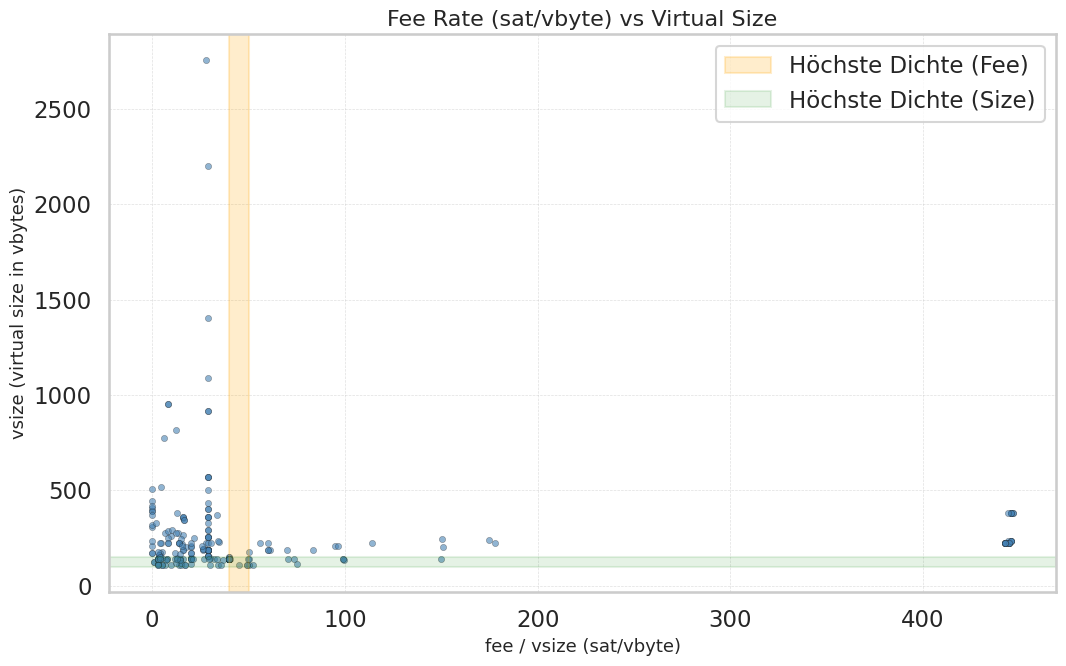

In [ ]:
def analyze_blocks(how_many):
    blocks = get_blocks_n(how_many)
    x_vals = []
    y_vals = []

    for block in blocks:
        print(f"Block Height: {block['height']} | Block ID: {block['id']}")
        print(f"Block Size: {block['size']} bytes")
        txs = get_transactions(block['id'])
        print(f"Transactions in Block: {len(txs)}")

        total_output = 0
        for tx in txs:
            txid = tx['txid']
            size = tx.get('size', 0)
            fee = tx.get('fee')
            weight = tx['weight']
            vsize = (weight + 3) // 4

            for out in tx['vout']:
                total_output += out['value']

            if fee is not None:
                sats_per_vbyte = fee / vsize
                x_vals.append(sats_per_vbyte)
                y_vals.append(vsize)

                print(f"  TXID: {txid}")
                print(f"    Size: {size} bytes")
                print(f"    Virtual Size: {vsize} vbytes")
                print(f"    Fee: {fee} satoshis")
                print(f"    Fee rate: {sats_per_vbyte:.2f} sat/vbyte")
                print(f"    Weight: {weight} wtu")

        print(f"Total Output in Block: {total_output / 100_000_000:.8f} BTC")
        print("-" * 50)

    # Durchschnittliche Werte berechnen
    avg_fee_rate = np.mean(x_vals)
    avg_vsize = np.mean(y_vals)

    print(f"\nDurchschnittliche Fee Rate: {avg_fee_rate:.2f} sat/vbyte")
    print(f"Durchschnittliche Transaktionsgröße: {avg_vsize:.2f} vbytes")

    # Ermittlung des dichtesten Bereichs (Heatmap)
    x_bins = np.arange(0, max(x_vals) + 10, 10) #hier wird die Schrittweite auf 10 gesetzt
    y_bins = np.arange(0, max(y_vals) + 50, 50) # Schrittweite auf 50 gesetzt

    heatmap, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=(x_bins, y_bins))
    max_density_idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)

    densest_x_range = (xedges[max_density_idx[0]], xedges[max_density_idx[0] + 1])# hier wird der Bereich der höchsten Dichte ermittelt
    densest_y_range = (yedges[max_density_idx[1]], yedges[max_density_idx[1] + 1])

    print(f"\nDichteste Region der Punkte:")
    print(f"  Fee Rate Bereich: {densest_x_range[0]:.2f} – {densest_x_range[1]:.2f} sat/vbyte")
    print(f"  Virtuelle Größe Bereich: {densest_y_range[0]:.2f} – {densest_y_range[1]:.2f} vbytes")

    # Visualisierung des Scatter-Plots
    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(11, 7))

    plt.scatter(x_vals, y_vals, alpha=0.6, s=20, color="steelblue", edgecolors='k', linewidth=0.3)

    plt.title("Fee Rate (sat/vbyte) vs Virtual Size", fontsize=16)
    plt.xlabel("fee / vsize (sat/vbyte)", fontsize=13)
    plt.ylabel("vsize (virtual size in vbytes)", fontsize=13)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Markiert den Bereich mit der höchsten Dichte
    plt.axvspan(densest_x_range[0], densest_x_range[1], color='orange', alpha=0.2, label='Höchste Dichte (Fee)')
    plt.axhspan(densest_y_range[0], densest_y_range[1], color='green', alpha=0.1, label='Höchste Dichte (Size)')
    plt.legend()

    plt.tight_layout()
    plt.show()

analyze_blocks(how_many)